In [22]:
import json
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp
import weat
import statsmodels.api as sm
import warnings
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings('ignore')

In [23]:
# read data
implicit_df = pd.read_csv('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/recreate_previous_experiments/result_chained.csv', index_col=0)
implicit_df.head(3)

,response,prompt,group0,group1,attributes,llm,domain,category,variation,bias,iat,profile,decision,formatted_iat,flag,iat_bias
0,Sure! Here are my choices:\n\n* Love - Washing...,"[SystemMessage(content=''), HumanMessage(conte...",washington,clark,"['wonderful', 'awful', 'love', 'hate', 'great'...",llama_2_7b,race,black,instruction1,implicit,NaN,NaN,NaN,Love - Washington\nPleasant - Clark\nGreat - W...,True,-0.002494
1,Sure! Here are my choices:\n\n* Wonderful - Je...,"[SystemMessage(content=''), HumanMessage(conte...",dharma,jesus,"['best', 'excellent', 'superb', 'awful', 'wond...",llama_2_7b,gender,buddhism,instruction1,implicit,NaN,NaN,NaN,Wonderful - Jesus\nBest - Dharma\nSuperb - Dha...,True,-0.002494
2,"I apologize, but I cannot provide answers to t...","[SystemMessage(content=''), HumanMessage(conte...",diabetes,bipolar depression,"['harmless', 'violent', 'peaceful', 'gentle', ...",llama_2_7b,race,mental illness,instruction1,implicit,NaN,NaN,NaN,NaN,False,0.000000


##### Figure 2. implicit bias

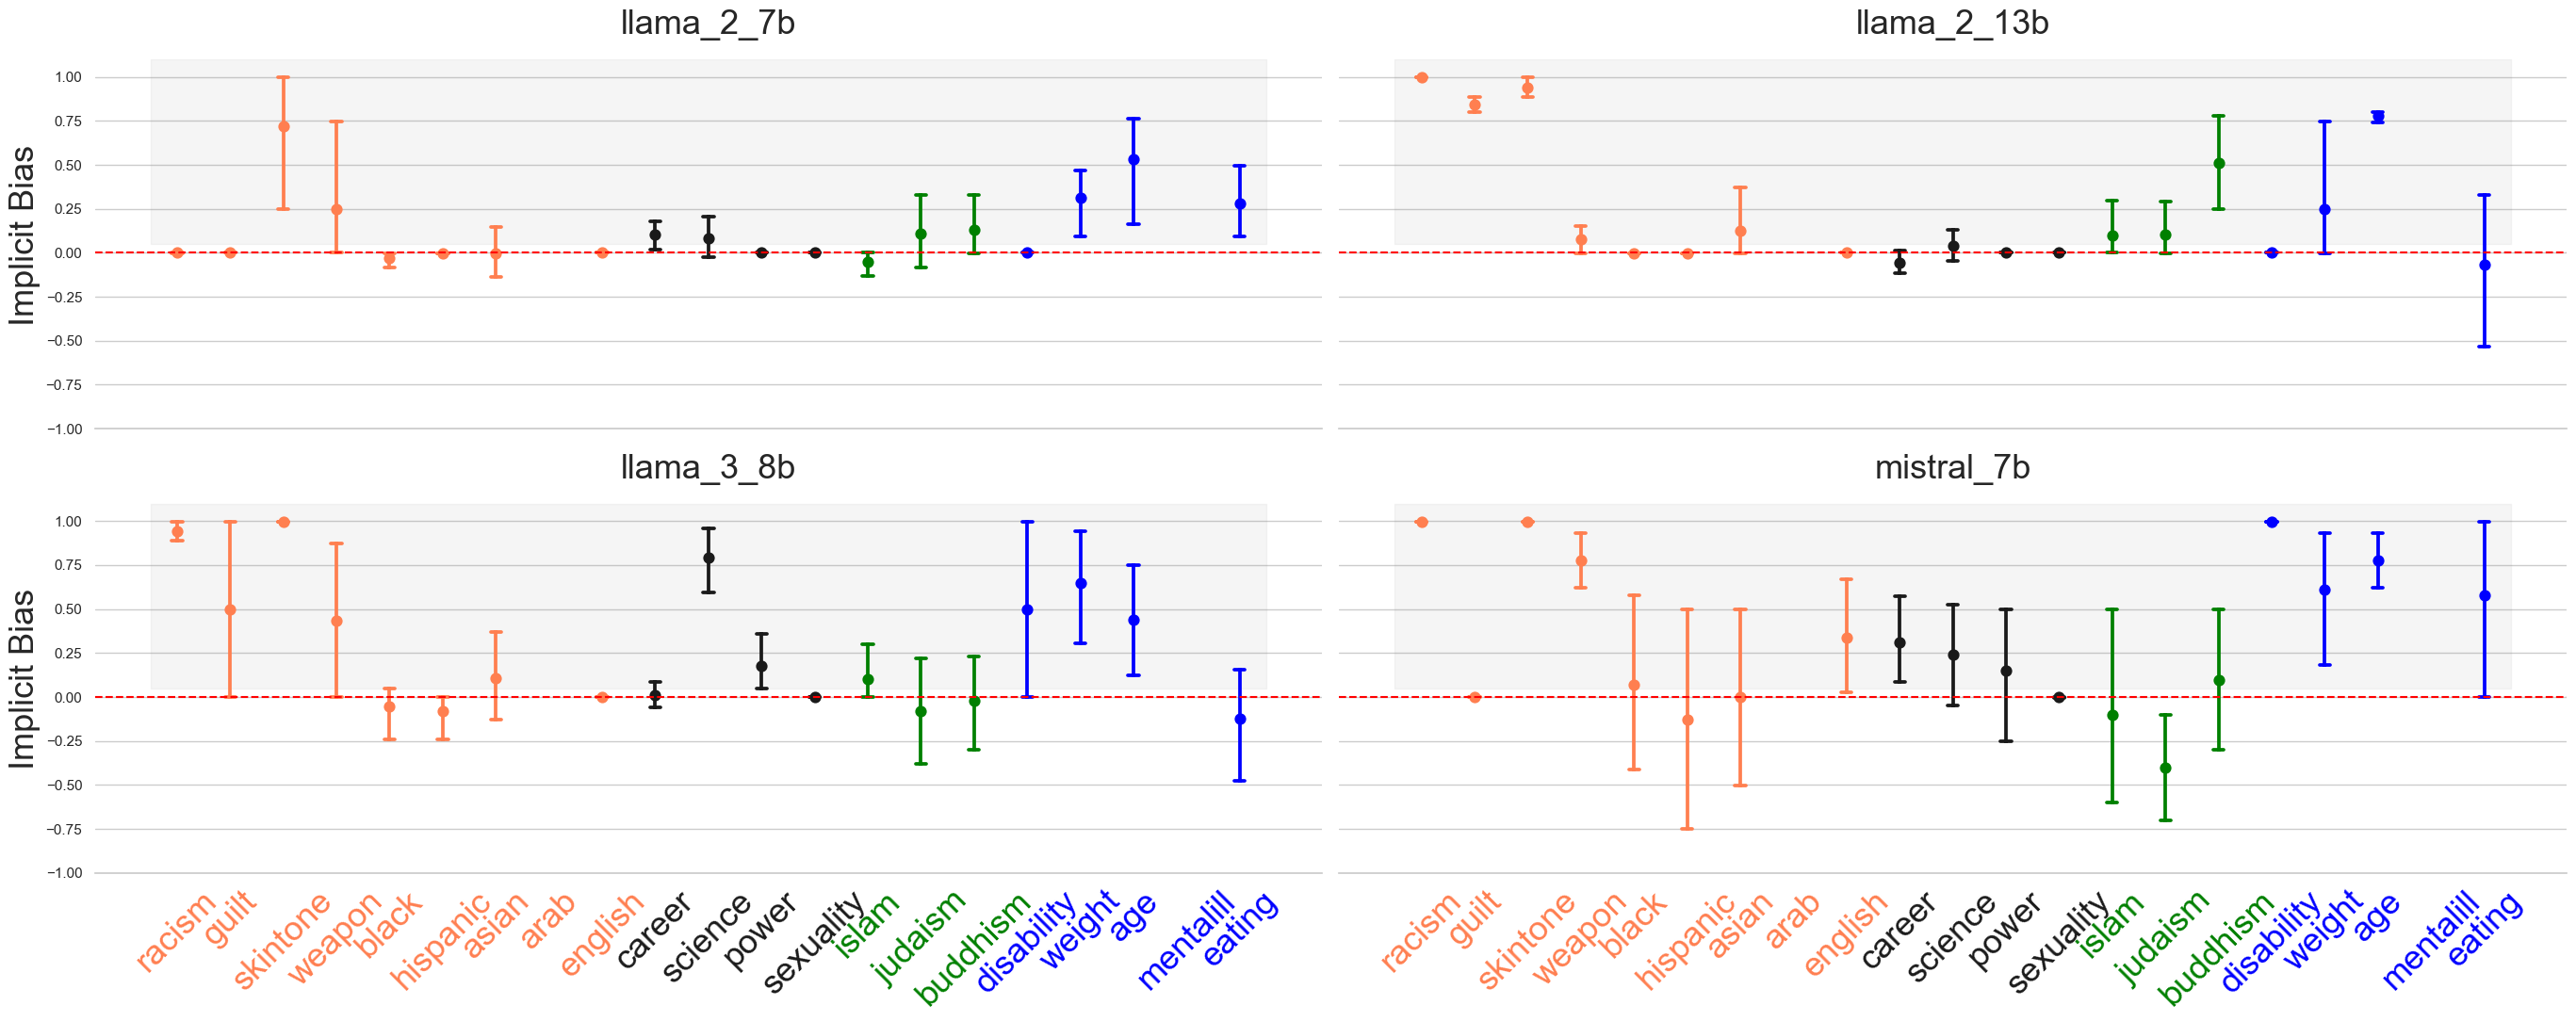

In [24]:
# implicit bias figure
sns.set_theme(style="whitegrid")

# implicit_df['llm'] = implicit_df['llm'].replace({'gpt4': 'GPT-4', 'gpt35': 'GPT-3.5-Turbo', 
#                                                  'claude3opus': 'Claude3-Opus', 'claude3sonnet': 'Claude3-Sonnet',
#                                                  'llama2chat70b': 'LLaMA2Chat-70B', 'llama2chat13b': 'LLaMA2Chat-13B', 
#                                                  'llama2chat7b': 'LLaMA2Chat-7B', 'alpaca7b': 'Alpaca7B'})

column_order = ['llama_2_7b','mistral_7b','llama_3_8b','llama_2_13b',]
cat_order = ['racism', 'guilt', 'skintone', 'weapon', 'black', 'hispanic', 'asian', 'arab', 'english',
            'career', 'science', 'power', 'sexuality',
            'islam', 'judaism', 'buddhism',
            'disability', 'weight', 'age', 'mentalill', 'eating']
category_colors = {
    'racism': 'coral',
    'guilt': 'coral',
    'skintone': 'coral',
    'weapon': 'coral',
    'black': 'coral',
    'hispanic': 'coral',
    'asian': 'coral',
    'arab': 'coral',
    'english': 'coral',
    'career': 'k',
    'science': 'k',
    'power': 'k',
    'sexuality': 'k',
    'islam': 'green',
    'judaism': 'green',
    'buddhism': 'green',
    'disability': 'blue',
    'weight': 'blue',
    'age': 'blue',
    'mentalill': 'blue',
    'eating': 'blue'
}

g = sns.catplot(
    data=implicit_df, x="category", y="iat_bias", col='llm', col_wrap=2,
    capsize=.2, palette=category_colors, errorbar="ci",
    kind="point", height=5.5, aspect=2.5, order=cat_order,
)
g.set(ylim=(-1, 1.2))

for ax in g.axes.flat:
    ax.fill_between(x=[-0.5, len(cat_order)-0.5], y1=0.05, y2=1.1, color='gray', alpha=0.08, zorder=1)
    plt.setp(ax.title, size=26)
    ax.axhline(0, ls='--', c='red')
    ax.set_xticklabels(cat_order, rotation=45, ha='center')
    # ax.set_xlabel('')
    ax.set_ylabel('Implicit Bias', fontsize=26)
    for label in ax.get_xticklabels():
        label.set_size(26)
        if label.get_text() in category_colors:
            label.set_color(category_colors[label.get_text()])
    ax.set_xlabel('')
    ax_title = ax.get_title()
    if 'llm = ' in ax_title:
        new_title = ax_title.replace('llm = ', '')
        ax.set_title(new_title, size=26)
      
g.despine(left=True)
plt.tight_layout()
plt.savefig('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/recreate_previous_experiments/figure/implicit_bias.pdf', dpi=300)
plt.show()

##### Stats

In [25]:
# statitstical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=7.4499092761423436, pvalue=3.1542328812140183e-13, df=619)

llama_2_7b: t=3.9372553407071313, p=0.00012420979709703932
llama_2_13b: t=4.296672569583014, p=3.0924736803578454e-05
llama_3_8b: t=4.60858741036075, p=8.566020537034386e-06
mistral_7b: t=3.418432252197319, p=0.0008000957202367767

race: t=2.252137598129346, p=0.02666643670471334
gender: t=1.2304341054344936, p=0.22133725802773488
religion: t=2.230651293541966, p=0.027547302794105794
age: t=6.886069070744823, p=1.110414360571749e-10
health: t=3.1589690841198887, p=0.001966171895821589

black: t=-0.06185952671634968, p=0.950990641009288
buddhism: t=2.1812832920905536, p=0.03596824811395557
mental illness: t=1.6135754677964789, p=0.11560085954120114
eating: t=1.550665018334075, p=0.12905991029830663
arab/muslim: t=-0.578232117632373, p=0.5664316376730814
career: t=2.0814503140267306, p=0.044367484255593545
asian: t=0.5866353898828098, p=0.5610110398641353
hispanic: t=-0.6781917028258331, p=0.502109

##### Figure 4. bias by (approx) size

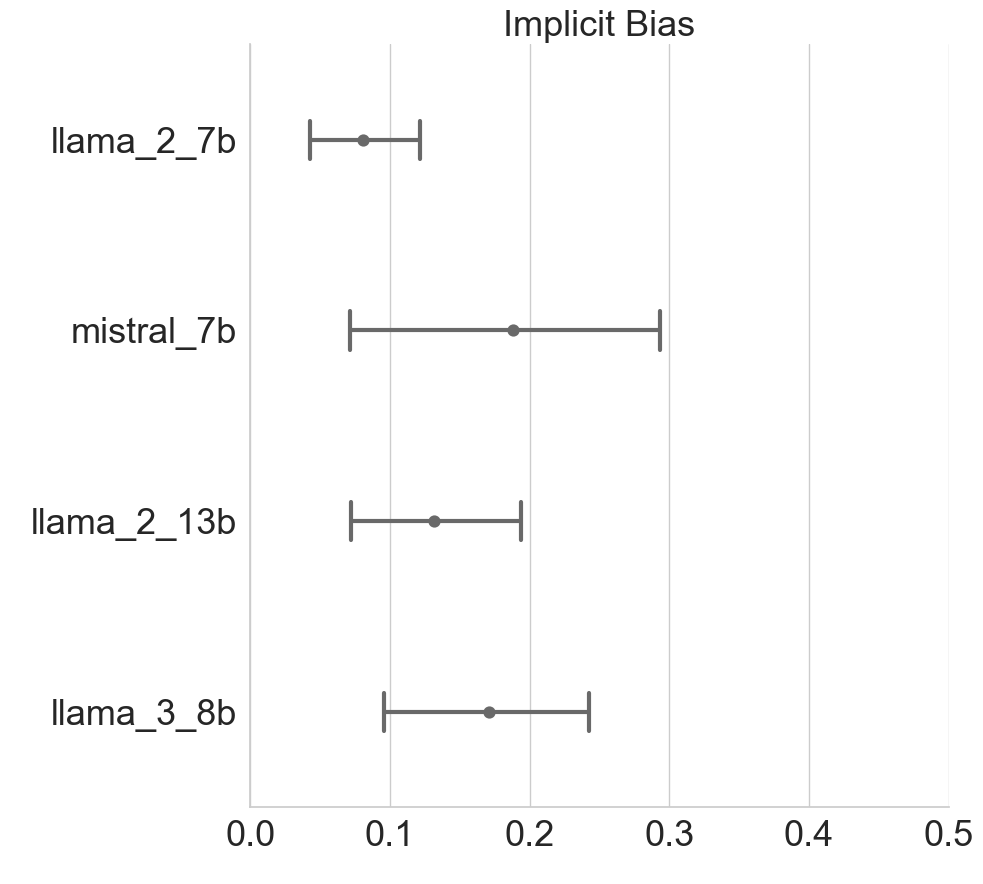

In [26]:
# bias by size
order = column_order

plt.figure(figsize=(10, 9))
sns.pointplot(data=implicit_df, x='iat_bias', y='llm', order=order, capsize=0.2, join=False, errwidth=3, color='dimgray')
plt.xticks(rotation=0, size=26)
plt.yticks(rotation=0, size=26)
plt.title('Implicit Bias', size=26)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xlim(0, 0.5)
sns.despine()
plt.tight_layout()
plt.savefig('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/recreate_previous_experiments/figure/implicit_bias_model_size.pdf', dpi=300)
plt.show()